In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import scienceplots
import seaborn as sns
from lobib import DataLoader
from lobib.utils import pl_select
from matplotlib.ticker import FuncFormatter

import qr.estimations as est

sns.set_style("whitegrid")

loader = DataLoader()

HOURS_PER_DAY = 5.5
DAY_NS = int(5.5 * 3600 * 1e9)  # 5.5 hours in nanoseconds
HOUR_NS = int(3600 * 1e9)
TICK_TO_USD = 0.01
FIVE_MIN_NS = int(5 * 60 * 1e9)

In [2]:
def preprocess_sim(df: pl.DataFrame) -> pl.DataFrame:
    df = df.with_columns((pl.col("ts_event") // DAY_NS).alias("date"))
    df = df.filter(~pl.col("rejected"))
    df = df.filter(~(pl.col("event").eq("Add") & pl.col("partial")))
    df = df.with_columns(pl.col("ts_event").diff().alias("dt"))
    condlist = [
        *[
            pl.col("imbalance").ge(left) & pl.col("imbalance").lt(right)
            for left, right in zip(-est.BINS[1:][::-1], -est.BINS[:-1][::-1])
        ],
        pl.col("imbalance").eq(0),
        *[
            pl.col("imbalance").gt(left) & pl.col("imbalance").le(right)
            for left, right in zip(est.BINS[:-1], est.BINS[1:])
        ],
    ]
    choicelist = [*(-est.BINS[1:][::-1]), 0, *est.BINS[1:]]
    df = df.with_columns(imbalance=pl_select(condlist, choicelist))
    return df.drop_nulls()

In [3]:
ticker = "PFE"
files = list(Path(f"../data/{ticker}/daily_estimates").glob("*.parquet"))
df = pl.scan_parquet(files)

In [4]:
df = df.collect()

In [5]:
df_sim = pl.read_parquet(
    "/home/labcmap/saad.souilmi/dev_cpp/qr/data/results/PFE/samples/960606ee.parquet"
)
df_sim = preprocess_sim(df_sim)

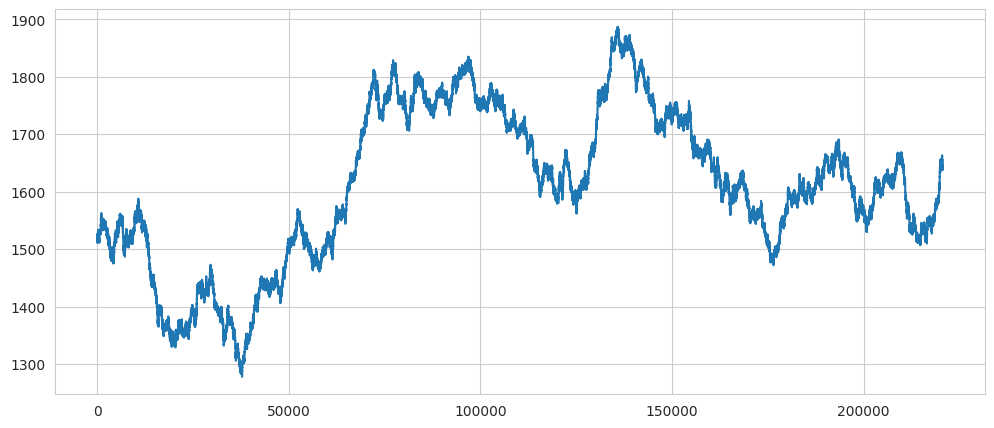

In [6]:
plt.figure(figsize=(12, 5))
plt.plot(df_sim[::100]["p_1"])

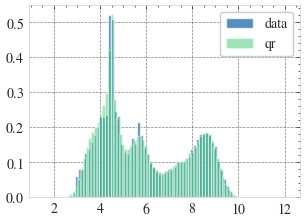

In [13]:
with plt.style.context(["science", "grid", "no-latex"]):
    fig = plt.figure(figsize=(3.5, 2.5))
    plt.hist(
        df["delta_t"].explode().log10(), bins=80, density=True, label="data", alpha=0.7
    )
    plt.hist(
        df_sim.filter(pl.col("dt") > 0)["dt"].log10(),
        bins=80,
        density=True,
        label="qr",
        alpha=0.4,
    )
    
    plt.legend()
    plt.show()

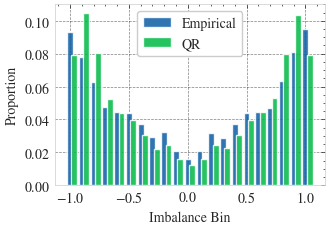

In [10]:
imb_dist = (
    df.filter(pl.col("event").eq("Trade"))
    .group_by("imbalance")
    .agg(pl.col("len").sum())
    .with_columns(proportion=pl.col("len") / pl.col("len").sum())
    .sort("imbalance")
)

imb_sim = (
    df_sim.filter(pl.col("event").eq("Trade"))["imbalance"]
    .value_counts(normalize=True)
    .sort("imbalance")
)

with plt.style.context(["science", "grid", "no-latex"]):
    fig, ax = plt.subplots(figsize=(3.5, 2.5))

    x = imb_dist["imbalance"]
    width = 0.05

    ax.bar(x, imb_dist["proportion"], width, label="Empirical", alpha=0.85)
    ax.bar(x + width *3/ 4, imb_sim["proportion"], width, label="QR", alpha=0.85)

    ax.set_xlabel("Imbalance Bin")
    ax.set_ylabel("Proportion")
    ax.legend()
    # ax.set_title(f"Binned imbalance distribution (before a trade) Ticker: {ticker}")
    plt.tight_layout()
    # fig.savefig("../paper/imb_distrib_before_trade_PFE.pdf", bbox_inches="tight")
    plt.show()

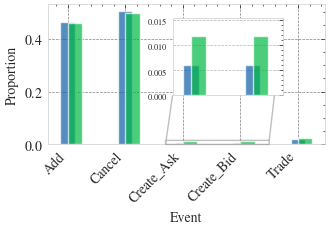

In [11]:
with plt.style.context(["science", "grid", "no-latex"]):
    fig, ax = plt.subplots(figsize=(3.5, 2.5))

    event_dist = (
        df.group_by("event")
        .agg(pl.col("len").sum())
        .with_columns(proportion=pl.col("len") / pl.col("len").sum())
        .sort("event")
    )
    event_dist_sim = df_sim["event"].value_counts(normalize=True).sort("event")

    labels = event_dist["event"]
    x = np.arange(len(labels))
    width = 0.25

    ax.bar(x, event_dist["proportion"], width, label="Empirical", alpha=0.7)
    ax.bar(
        x + width / 2,
        event_dist_sim["proportion"],
        width,
        label="QR",
        alpha=0.7,
    )

    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_xlabel("Event")
    ax.set_ylabel("Proportion")
    # ax.legend()

    # Zoom patch on Create_Bid / Create_Ask region
    create_idx = [i for i, l in enumerate(labels) if "Create" in l]
    x1 = min(create_idx) - 0.3
    x2 = max(create_idx) + 0.5
    y1 = 0
    y2 = (
        max(
            max(event_dist["proportion"][i] for i in create_idx),
            max(event_dist_sim["proportion"][i] for i in create_idx),
        )
        * 1.3
    )

    axins = ax.inset_axes([0.45, 0.35, 0.4, 0.55])
    axins.bar(
        x[create_idx],
        [event_dist["proportion"][i] for i in create_idx],
        width,
        alpha=0.7,
    )
    axins.bar(
        x[create_idx] + width / 2,
        [event_dist_sim["proportion"][i] for i in create_idx],
        width,
        alpha=0.7,
    )
    axins.set_xticks([])
    # axins.set_xticklabels([labels[i] for i in create_idx], fontsize=6, rotation=45, ha="right")
    axins.tick_params(labelsize=6)
    axins.grid(True, alpha=0.3)
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)

    ax.indicate_inset_zoom(axins, edgecolor="grey", alpha=0.5)

    plt.tight_layout()
    # fig.savefig("../paper/emp_vs_qr_event_distrib_PFE.pdf", bbox_inches="tight")
    plt.show()

In [59]:
probabilities = pl.read_csv(f"../data/{ticker}/qr_params/event_probabilities.csv")

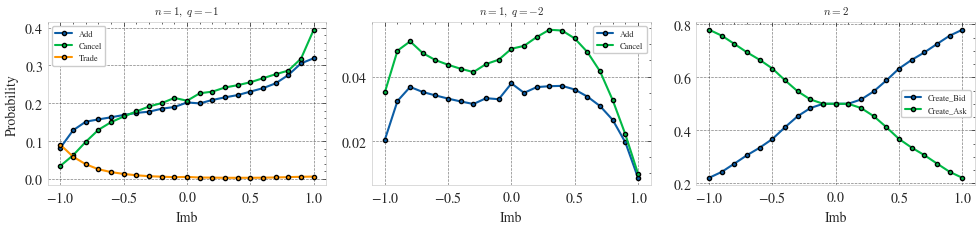

In [63]:
probs = pl.concat(
    [
        probabilities.filter(pl.col("imbalance").ne(0)).with_columns(
            imbalance=-pl.col("imbalance"),
            side=-pl.col("side"),
            queue=-pl.col("queue"),
            event=pl.col("event").replace(
                {"Create_Ask": "Create_Bid", "Create_Bid": "Create_Ask"}
            ),
        ),
        probabilities,
    ]
).sort("imbalance", "spread", "event", "queue")

with plt.style.context(["science", "grid", "no-latex"]):
    fig, axes = plt.subplots(1, 3, figsize=(10, 2.5))

    configs = [
        (1, -1, ["Add", "Cancel", "Trade"], r"$n=1,\; q=-1$"),
        (1, -2, ["Add", "Cancel"], r"$n=1,\; q=-2$"),
        (2, 0, ["Create_Bid", "Create_Ask"], r"$n=2$"),
    ]

    for ax, (spread, queue, events, title) in zip(axes, configs):
        if queue != 0:
            sub = probs.filter(pl.col("spread").eq(spread) & pl.col("queue").eq(queue))
        else:
            sub = probs.filter(pl.col("spread").eq(spread))
        for event in events:
            data = sub.filter(pl.col("event").eq(event)).sort("imbalance")
            ax.plot(
                data["imbalance"],
                data["probability"],
                marker="o",
                ms=3,
                lw=1.5,
                label=event,
                mec="k",
            )
        ax.set_xlabel("Imb")
        ax.set_title(title, fontsize=8)
        ax.legend(fontsize=6)

    axes[0].set_ylabel("Probability")
    fig.tight_layout()
    plt.show()

In [64]:
size_distrib = pl.read_csv(f"../data/{ticker}/qr_params/size_distrib.csv")

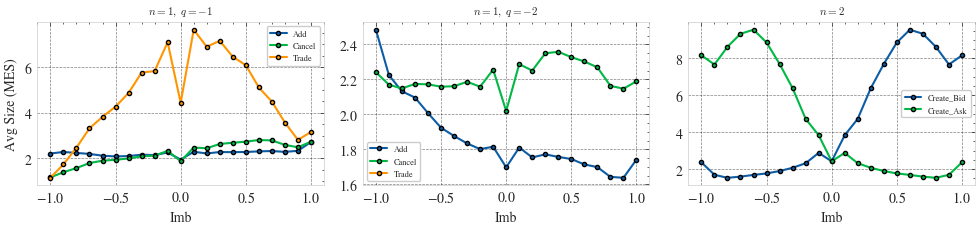

In [67]:
sizes = pl.concat(
    [
        size_distrib.filter(pl.col("imbalance").ne(0)).with_columns(
            imbalance=-pl.col("imbalance"),
            side=-pl.col("side"),
            queue=-pl.col("queue"),
            event=pl.col("event").replace(
                {"Create_Ask": "Create_Bid", "Create_Bid": "Create_Ask"}
            ),
        ),
        size_distrib,
    ]
).sort("imbalance", "spread", "event", "queue")

with plt.style.context(["science", "grid", "no-latex"]):
    fig, axes = plt.subplots(1, 3, figsize=(10, 2.5))

    configs = [
        (1, -1, ["Add", "Cancel", "Trade"], r"$n=1,\; q=-1$"),
        (1, -2, ["Add", "Cancel", "Trade"], r"$n=1,\; q=-2$"),
        (2, 0, ["Create_Bid", "Create_Ask"], r"$n=2$"),
    ]

    for ax, (spread, queue, events, title) in zip(axes, configs):
        if queue != 0:
            sub = sizes.filter(pl.col("spread").eq(spread) & pl.col("queue").eq(queue))
        else:
            sub = sizes.filter(pl.col("spread").eq(spread))
        for event in events:
            data = sub.filter(pl.col("event").eq(event)).sort("imbalance")
            ax.plot(
                data["imbalance"],
                1 / data["p"],
                marker="o",
                ms=3,
                lw=1.5,
                label=event,
                mec="k",
            )
        ax.set_xlabel("Imb")
        ax.set_title(title, fontsize=8)
        ax.legend(fontsize=6)

    axes[0].set_ylabel("Avg Size (MES)")
    fig.tight_layout()
    plt.show()

In [7]:
volumes = (
    df.group_by("imbalance", "spread", "event", "queue", "side")
    .agg(pl.col("len").sum(), pl.col("size").flatten())
    .collect()
)

In [14]:
volumes.filter(pl.col("event").eq("Trade"))

imbalance,spread,event,queue,side,len,size
f64,i32,str,i32,i64,u32,list[i64]
-0.6,1,"""Trade""",1,1,8452,"[10, 1, … 6]"
-0.9,1,"""Trade""",-1,-1,89659,"[23, 41, … 532]"
-0.1,1,"""Trade""",-1,-1,14938,"[15, 1, … 58]"
-1.0,1,"""Trade""",1,1,8117,"[12, 9, … 97]"
0.7,1,"""Trade""",1,1,52112,"[47, 99, … 913]"
…,…,…,…,…,…,…
0.7,1,"""Trade""",-1,-1,7326,"[12, 14, … 68]"
0.4,1,"""Trade""",1,1,36077,"[9, 71, … 13]"
0.0,1,"""Trade""",-1,-1,10463,"[69, 6, … 192]"


In [3]:
delta_t = est.group_delta_t(df)

In [3]:
count = df.group_by("imbalance").agg(pl.col("len").sum()).sort("imbalance").collect()

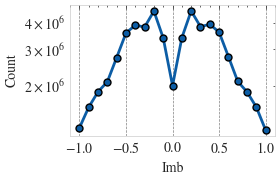

In [5]:
with plt.style.context(["science", "grid", "no-latex"]):
    fig, ax = plt.subplots(figsize=(3, 2))
    ax.plot(
        count["imbalance"],
        count["len"],
        marker="o",
        mec="k",
        ms=5,
        lw=2,
    )
    ax.set_xlabel("Imb")
    ax.set_ylabel("Count")
    ax.ticklabel_format(style="scientific", axis="y", scilimits=(0, 0))
    ax.set_yscale("log")
    ax.set_xticks([-1, -0.5, 0, 0.5, 1])
    fig.tight_layout()
    plt.show()
    fig.savefig("../paper/imb_count_PFE.pdf", bbox_inches="tight")

In [6]:
delta_t = est.exp_delta_t(df)

In [26]:
delta_t

imbalance,spread,average_dt
f64,i32,f64
0.0,1,2.0055e8
0.0,2,5.7074e8
0.1,1,1.9903e8
0.1,2,2.9125e7
0.2,1,1.9636e8
…,…,…
0.8,2,7.2696e6
0.9,1,8.9414e7
0.9,2,3.2866e7


In [7]:
dates = df.select("date").collect().unique()["date"].to_list()

In [8]:
df = []
median_event_sizes, total_best_quantiles = est.load_params(
    f"../data/{ticker}/daily_estimates/params.json"
)
for date in dates:
    df.append(
        est.preprocess(
            loader.load(ticker, start_date=date, end_date=date, schema="qr"),
            median_event_sizes,
            est.BINS,
            total_best_quantiles,
        )
    )

In [9]:
df = pl.concat(df)

In [10]:
spread_dist = (
    df.filter(pl.col("event").eq("Trade"))
    .select(pl.col("spread").value_counts(normalize=True))
    .unnest("spread")
    .sort("spread")
    .filter(pl.col("spread") <= 5)
).collect()

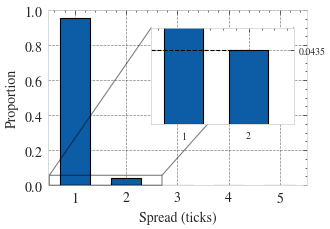

In [11]:
spreads = spread_dist["spread"].to_numpy()
props = spread_dist["proportion"].to_numpy()
val_2 = props[spreads == 2][0]

with plt.style.context(["science", "grid", "no-latex"]):
    fig, ax = plt.subplots(figsize=(3.5, 2.5))
    ax.bar(spreads, props, width=0.6, edgecolor="k", linewidth=0.8)
    ax.set_xticks(spreads)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Spread (ticks)")
    ax.set_ylabel("Proportion")

    # Inset zoom
    axins = ax.inset_axes([0.4, 0.35, 0.55, 0.55])
    axins.bar(spreads, props, width=0.6, edgecolor="k", linewidth=0.8)
    axins.set_xlim(0.5, 2.7)
    axins.set_ylim(0, val_2 * 1.3)
    axins.set_xticks([1, 2])
    axins.hlines(
        val_2, axins.get_xlim()[0], 2, linestyles="--", colors="k", linewidth=0.8
    )
    axins.set_yticks([val_2])
    axins.yaxis.tick_right()
    axins.set_yticklabels([f"{val_2:.4f}"], fontsize=16)
    axins.tick_params(labelsize=7)

    # Connect zoom region to inset
    ax.indicate_inset_zoom(axins, edgecolor="k", linewidth=0.8)

    fig.tight_layout()
    plt.show()
    fig.savefig("../paper/spread_before_trades_pfe.pdf", bbox_inches="tight")

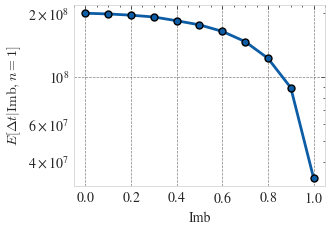

In [8]:
with plt.style.context(["science", "grid", "no-latex"]):
    fig, ax = plt.subplots(figsize=(3.5, 2.5))
    ax.plot(
        delta_t.filter(pl.col("spread").eq(1))["imbalance"],
        delta_t.filter(pl.col("spread").eq(1))["average_dt"],
        marker="o",
        mec="k",
        ms=5,
        lw=2,
    )
    ax.set_xlabel("Imb")
    ax.set_ylabel(r"$E[\Delta t | \text{Imb}, n=1]$")
    ax.ticklabel_format(style="scientific", axis="y", scilimits=(0, 0))
    ax.set_yscale("log")
    fig.tight_layout()
    plt.show()
    fig.savefig("../paper/avg_delta_t_PFE.pdf", bbox_inches="tight")

In [13]:
dt = df.select(pl.col("delta_t").explode().log10()).collect()["delta_t"].drop_nulls()

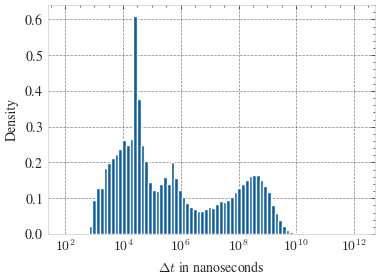

In [14]:
with plt.style.context(["science", "grid", "no-latex"]):
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.hist(dt, bins=80, density=True)
    ax.set_xlabel(r"$\Delta t$ in nanoseconds")
    ax.set_ylabel("Density")
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"$10^{{{int(x)}}}$"))
    fig.tight_layout()
    plt.show()
    fig.savefig("../paper/delta_t_global_PFE.pdf", bbox_inches="tight")

In [15]:
from scipy.stats import norm
from sklearn.mixture import GaussianMixture

x = dt.to_numpy().reshape(-1, 1)
gmm = GaussianMixture(n_components=5, random_state=1337).fit(x)

x_grid = np.linspace(x.min(), x.max(), 500)

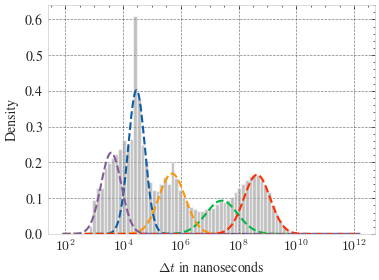

In [16]:
with plt.style.context(["science", "grid", "no-latex"]):
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.hist(dt, bins=80, alpha=0.5, density=True, color="gray")

    # Individual components
    for i in range(5):
        y = gmm.weights_[i] * norm.pdf(
            x_grid, gmm.means_[i, 0], np.sqrt(gmm.covariances_[i, 0, 0])
        )
        ax.plot(x_grid, y, "--", lw=1.5, label=f"k={i+1}")

    # # Total mixture
    # log_prob = gmm.score_samples(x_grid.reshape(-1, 1))
    # ax.plot(x_grid, np.exp(log_prob), "k-", lw=2, label="GMM")

    ax.set_xlabel(r"$\Delta t$ in nanoseconds")
    ax.set_ylabel("Density")
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"$10^{{{int(x)}}}$"))
    # ax.legend(fontsize=7)
    fig.tight_layout()
    plt.show()
    fig.savefig("../paper/delta_t_global_PFE_gmm.pdf", bbox_inches="tight")

In [4]:
delta_t = (
    df.group_by("imbalance", "spread", "event", "queue", "side")
    .agg(pl.col("delta_t").flatten(), pl.col("len").sum())
    .collect()
)
delta_t = symmetrise_delta_t(delta_t)

In [48]:
def fit_gmm(df: pl.DataFrame, k: int = 5, random_state: int = 1337) -> pl.DataFrame:
    rows = []
    for row in tqdm(df.iter_rows(named=True), total=len(df), desc="Fitting GMMs"):
        x = np.log10(np.array(row["delta_t"], dtype=float)).reshape(-1, 1)
        gmm = GaussianMixture(n_components=k, random_state=random_state).fit(x)
        entry = {
            "imbalance": row["imbalance"],
            "spread": row["spread"],
            "event": row["event"],
            "queue": row["queue"],
            "side": row["side"],
        }
        for i in range(k):
            entry[f"w_{i+1}"] = gmm.weights_[i]
            entry[f"mu_{i+1}"] = gmm.means_[i, 0]
            entry[f"sig_{i+1}"] = np.sqrt(gmm.covariances_[i, 0, 0])
        rows.append(entry)
    return pl.DataFrame(rows)

In [49]:
gmm_fit = fit_gmm(delta_t)

Fitting GMMs: 100%|████████████████████████████████████████████████████████████| 132/132 [09:03<00:00,  4.12s/it]


In [22]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
from tqdm import tqdm

max_k = 8
global_bic = {k: 0.0 for k in range(1, max_k + 1)}

rows = list(delta_t.iter_rows(named=True))
for row in tqdm(rows, desc="Fitting GMMs"):
    x = np.log10(np.array(row["delta_t"], dtype=float)).reshape(-1, 1)
    if len(x) > 10000:
        x = np.random.default_rng(0).choice(x, 10000, replace=False)
    for k in range(1, max_k + 1):
        gmm = GaussianMixture(n_components=k, random_state=0).fit(x)
        global_bic[k] += gmm.bic(x)

Fitting GMMs: 100%|████████████████████████████████████████████████████████████| 132/132 [03:07<00:00,  1.42s/it]


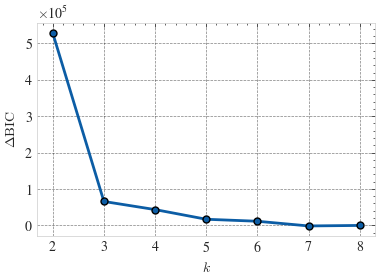

In [41]:
from matplotlib.ticker import FuncFormatter

with plt.style.context(["science", "grid", "no-latex"]):
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.plot(range(2, max_k + 1), deltas, marker="o", mec="k", ms=5, lw=2)
    ax.set_xlabel(r"$k$")
    ax.set_ylabel(r"$\Delta\mathrm{BIC}$")
    ax.ticklabel_format(style="scientific", axis="y", scilimits=(0, 0))
    fig.tight_layout()
    plt.show()

In [89]:
stats = (
    df.group_by("imbalance", "spread", "total_best", "queue", "side", "event")
    .agg(pl.col("len").sum(), pl.col("delta_t_sum").sum())
    .collect()
)

In [90]:
stats = (
    stats.group_by("imbalance", "spread", "total_best")
    .agg(pl.col("delta_t_sum").sum() / pl.col("len").sum(), pl.col("len").sum())
    .sort("imbalance")
)

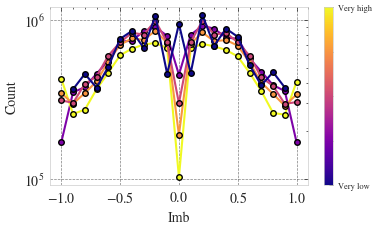

In [91]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

norm = mcolors.Normalize(vmin=0, vmax=4)
cmap = cm.plasma

with plt.style.context(["science", "grid", "no-latex"]):
    fig, ax = plt.subplots(figsize=(4, 2.5))
    for (total_best,), data in stats.filter(pl.col("spread").eq(1)).group_by(
        "total_best"
    ):
        ax.plot(
            data["imbalance"],
            data["len"],
            marker="o",
            ms=4,
            lw=1.5,
            mec="k",
            color=cmap(norm(total_best)),
        )
    ax.set_xlabel("Imb")
    ax.set_ylabel("Count")
    ax.set_yscale("log")

    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = fig.colorbar(sm, ax=ax, ticks=[0, 4])
    cbar.ax.set_yticklabels(["Very low", "Very high"], fontsize=6)

    fig.tight_layout()
    plt.show()
    fig.savefig("../paper/count_imb_total_best_PFE.pdf", bbox_inches="tight")

In [92]:
stats = (
    df.group_by("imbalance", "spread", "total_best", "queue", "side", "event")
    .agg(pl.col("len").sum(), pl.col("delta_t_sum").sum())
    .collect()
)
stats = (
    stats.group_by(pl.col("imbalance").abs(), "spread", "total_best")
    .agg(pl.col("delta_t_sum").sum() / pl.col("len").sum(), pl.col("len").sum())
    .sort("imbalance")
)

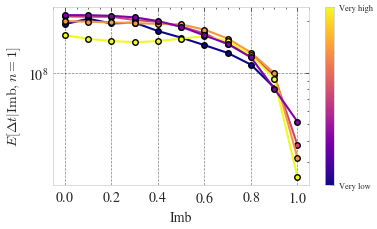

In [93]:
with plt.style.context(["science", "grid", "no-latex"]):
    fig, ax = plt.subplots(figsize=(4, 2.5))
    for (total_best,), data in stats.filter(pl.col("spread").eq(1)).group_by(
        "total_best"
    ):
        ax.plot(
            data["imbalance"],
            data["delta_t_sum"],
            marker="o",
            ms=4,
            lw=1.5,
            mec="k",
            color=cmap(norm(total_best)),
        )
    ax.set_xlabel("Imb")
    ax.set_ylabel(r"$E[\Delta t | \text{Imb}, n=1]$")
    ax.set_yscale("log")

    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = fig.colorbar(sm, ax=ax, ticks=[0, 4])
    cbar.ax.set_yticklabels(["Very low", "Very high"], fontsize=6)

    fig.tight_layout()
    plt.show()
    fig.savefig("../paper/avg_delta_t_total_best_PFE.pdf", bbox_inches="tight")

In [94]:
stats = df.group_by("imbalance", "spread", "total_best", "queue", "side", "event").agg(
    pl.col("len").sum(), pl.col("delta_t_sum").sum()
)

In [95]:
stats = stats.with_columns(
    total_len_cat=pl.col("len").sum().over("imbalance", "spread", "total_best")
)

In [96]:
probabilities_3d = stats.select(
    "imbalance",
    "spread",
    "total_best",
    "queue",
    "side",
    "event",
    probability=pl.col("len").truediv(pl.col("total_len_cat")),
).sort("imbalance", "spread", "total_best", "queue", "side", "event")

In [97]:
probabilities_3d = probabilities_3d.collect()

In [98]:
pos = probabilities_3d.filter(pl.col("imbalance") >= 0)
neg = probabilities_3d.filter(pl.col("imbalance") <= 0).with_columns(
    imbalance=-pl.col("imbalance"),
    side=-pl.col("side"),
    queue=-pl.col("queue"),
    event=pl.col("event").replace(
        {"Create_Ask": "Create_Bid", "Create_Bid": "Create_Ask"}
    ),
)

probabilities_3d = (
    pl.concat([pos, neg])
    .group_by("imbalance", "spread", "total_best", "event", "queue", "side")
    .agg(
        probability=pl.col("probability").mean(),
    )
)

In [99]:
probabilities_3d = probabilities_3d.sort(
    "imbalance", "spread", "total_best", "event", "queue"
)

In [100]:
probs = pl.concat(
    [
        probabilities_3d.filter(pl.col("imbalance").ne(0)).with_columns(
            imbalance=-pl.col("imbalance"),
            side=-pl.col("side"),
            queue=-pl.col("queue"),
            event=pl.col("event").replace(
                {"Create_Ask": "Create_Bid", "Create_Bid": "Create_Ask"}
            ),
        ),
        probabilities_3d,
    ]
).sort("imbalance", "spread", "event", "queue")
probs = probs.filter(pl.col("spread").eq(1) & pl.col("queue").eq(-1))

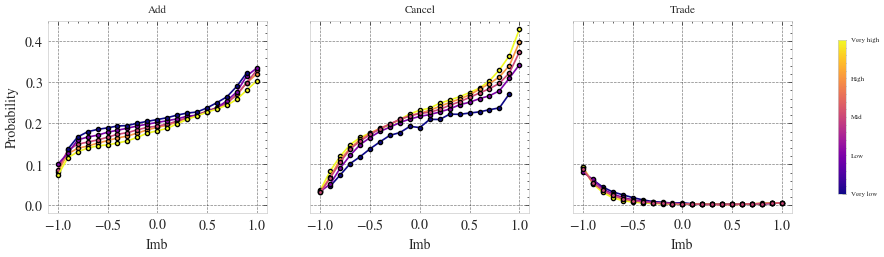

In [101]:
probs_bid = probs.filter(pl.col("spread").eq(1) & pl.col("queue").eq(-1))

with plt.style.context(["science", "grid", "no-latex"]):
    fig, axes = plt.subplots(1, 3, figsize=(12, 2.5), sharey=True)

    for ax, event in zip(axes, ["Add", "Cancel", "Trade"]):
        data = probs_bid.filter(pl.col("event").eq(event))
        for (tb,), group in data.group_by("total_best"):
            group = group.sort("imbalance")
            ax.plot(
                group["imbalance"],
                group["probability"],
                marker="o",
                ms=3,
                lw=1.2,
                mec="k",
                color=cmap(norm(tb)),
            )
        ax.set_xlabel("Imb")
        ax.set_title(event, fontsize=8)

    axes[0].set_ylabel("Probability")

    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = fig.colorbar(sm, ax=axes, ticks=[0, 1, 2, 3, 4], shrink=0.8)
    cbar.ax.set_yticklabels(["Very low", "Low", "Mid", "High", "Very high"], fontsize=5)

    # fig.tight_layout()
    plt.show()
    fig.savefig("../paper/probabilities_total_best_PFE.pdf", bbox_inches="tight")

In [3]:
stats = df.group_by("imbalance", "spread", "queue", "side", "event").agg(
    pl.col("len").sum(), pl.col("delta_t_sum").sum()
)
stats = stats.with_columns(
    total_len_cat=pl.col("len").sum().over("imbalance", "spread")
)

stats = stats.collect()
pos = stats.filter(pl.col("imbalance") >= 0)
neg = stats.filter(pl.col("imbalance") <= 0).with_columns(
    imbalance=-pl.col("imbalance"),
    side=-pl.col("side"),
    queue=-pl.col("queue"),
    event=pl.col("event").replace(
        {"Create_Ask": "Create_Bid", "Create_Bid": "Create_Ask"}
    ),
)

probabilities = (
    pl.concat([pos, neg])
    .group_by("imbalance", "spread", "event", "queue", "side")
    .agg(probability=pl.col("len").sum().truediv(pl.col("total_len_cat").sum()))
    .sort("imbalance", "spread", "event", "queue")
)

probability
f64
1.0
1.0
1.0
1.0
1.0
…
1.0
1.0
1.0


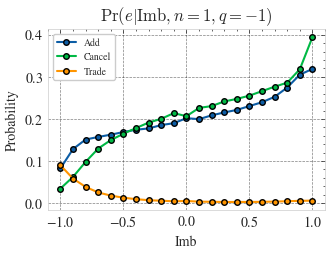

In [24]:
probs = pl.concat(
    [
        probabilities.filter(pl.col("imbalance").ne(0)).with_columns(
            imbalance=-pl.col("imbalance"),
            side=-pl.col("side"),
            queue=-pl.col("queue"),
            event=pl.col("event").replace(
                {"Create_Ask": "Create_Bid", "Create_Bid": "Create_Ask"}
            ),
        ),
        probabilities,
    ]
).sort("imbalance", "spread", "event", "queue")
probs = probs.filter(pl.col("spread").eq(1) & pl.col("queue").eq(-1))

with plt.style.context(["science", "grid", "no-latex"]):
    fig, ax = plt.subplots(figsize=(3.5, 2.5))
    for event in ["Add", "Cancel", "Trade"]:
        data = probs.filter(pl.col("event").eq(event))
        ax.plot(
            data["imbalance"],
            data["probability"],
            marker="o",
            ms=4,
            lw=1.5,
            label=event,
            mec="k",
        )
    ax.set_xlabel("Imb")
    ax.set_ylabel("Probability")
    ax.legend(fontsize=7)
    fig.tight_layout()
    plt.title(r"$\text{Pr}(e | \text{Imb}, n=1, q=-1)$")
    plt.show()
    fig.savefig("../paper/event_probabilities_spread_1_bid_PFE.pdf")

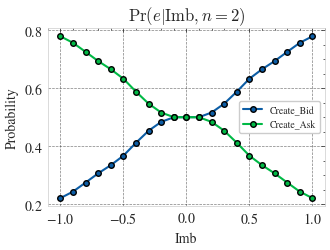

In [28]:
probs = pl.concat(
    [
        probabilities.filter(pl.col("imbalance").ne(0)).with_columns(
            imbalance=-pl.col("imbalance"),
            side=-pl.col("side"),
            queue=-pl.col("queue"),
            event=pl.col("event").replace(
                {"Create_Ask": "Create_Bid", "Create_Bid": "Create_Ask"}
            ),
        ),
        probabilities,
    ]
).sort("imbalance", "spread", "event", "queue")
probs = probs.filter(pl.col("spread").eq(2))

with plt.style.context(["science", "grid", "no-latex"]):
    fig, ax = plt.subplots(figsize=(3.5, 2.5))
    for event in ["Create_Bid", "Create_Ask"]:
        data = probs.filter(pl.col("event").eq(event))
        ax.plot(
            data["imbalance"],
            data["probability"],
            marker="o",
            ms=4,
            lw=1.5,
            label=event,
            mec="k",
        )
    ax.set_xlabel("Imb")
    ax.set_ylabel("Probability")
    ax.legend(fontsize=7)
    fig.tight_layout()
    plt.title(r"$\text{Pr}(e | \text{Imb}, n=2)$")
    plt.show()
    fig.savefig("../paper/event_probabilities_spread_2_PFE.pdf")

In [6]:
imbalances = probabilities_3d["imbalance"].unique()
total_bests = probabilities_3d["total_best"].unique()

spread1_combos = (
    pl.DataFrame({"imbalance": imbalances})
    .join(pl.DataFrame({"total_best": total_bests}), how="cross")
    .join(pl.DataFrame({"event": ["Add", "Cancel", "Trade"]}), how="cross")
    .join(pl.DataFrame({"queue": [-2, -1, 1, 2]}), how="cross")
    .with_columns(
        spread=pl.lit(1),
        side=pl.when(pl.col("queue") > 0).then(1).otherwise(-1),
    )
).with_columns(pl.col("queue").cast(pl.Int32))

spread2_combos = (
    pl.DataFrame({"imbalance": imbalances})
    .join(pl.DataFrame({"total_best": total_bests}), how="cross")
    .join(
        pl.DataFrame(
            {
                "event": ["Create_Ask", "Create_Bid"],
                "side": [1, -1],
            }
        ),
        how="cross",
    )
    .with_columns(
        spread=pl.lit(2),
        queue=pl.lit(0),
    )
).select(
    "imbalance", "total_best", "event", "queue", "spread", pl.col("side").cast(pl.Int32)
)

valid_combos = pl.concat([spread1_combos, spread2_combos])